In [4]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import math
import scipy.linalg as la
from scipy import optimize as opt
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

    fjac: array([[-0.89516086,  0.44574324],
       [-0.44574324, -0.89516086]])
     fun: array([ -4.54747351e-13,   3.69482223e-13])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([ -3.29127994e-08,   4.82744477e-09])
       r: array([-12326.81535242,   4292.61819313,  -4410.65221336])
  status: 1
 success: True
       x: array([ 0.01931273,  0.05841156])


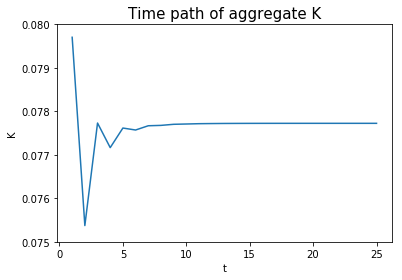

In [54]:
#Household parameters
'''
Sigma is a scalar >= 1, represents coefficient of relative risk aversion 
'''
nvec = np.array([1.0, 1.0, 0.2])
yrs_lived = 60
S = 3
beta_annual = 0.96
beta = beta_annual ** (yrs_lived / S)
#beta = 0.55
sigma = 3 

#Firm parameters
alpha = 0.35 #how much is allocated to capital owners in economy
A = 1
delta_annual = 0.05
delta = 1 - (1 - delta_annual) ** (yrs_lived / S) 
params = (A, alpha, delta) 

#Market clearing conditions

L = np.sum(nvec)

#Firm's optimization problem

def getr(K, L, params):
    A, alpha, delta = params
    r = alpha * A * ((L / K) ** (1 - alpha)) - delta
    return r

def getw(K, L, params):
    A, alpha, delta = params
    w = (1 - alpha) * A * ((K / L) ** (alpha)) 
    return w

#Household's optimization problem

def getmuc1(b2b3vals, nvec, sigma, params, r, w):
    b2, b3 = b2b3vals
    K = sum(b2b3vals)
    ct1 = nvec[0] * w - b2 
    MUc1 = ct1 ** (-sigma)
    return MUc1

def getmuc2(b2b3vals, nvec, sigma, params, r, w):
    b2, b3 = b2b3vals
    K = np.sum(b2b3vals)
    ct2 = nvec[1] * w + (1 + r) * b2 - b3
    MUc2 = ct2 ** (-sigma)
    return MUc2

def getmuc3(b2b3vals, nvec, sigma, params, r, w):
    b2, b3 = b2b3vals
    K = np.sum(b2b3vals)
    ct3 = nvec[2] * w + (1 + r) * b3
    MUc3 = ct3 ** (-sigma)
    return MUc3

def errorcal(b2b3vals, args):
    beta, sigma, params, nvec = args
    b2, b3 = b2b3vals
    K = np.sum(b2b3vals)
    L = np.sum(nvec)
    r = getr(K, L, params)
    w = getw(K, L, params)
    MUc1 = getmuc1(b2b3vals, nvec, sigma, params, r, w)
    MUc2 = getmuc2(b2b3vals, nvec, sigma, params, r, w)
    MUc3 = getmuc3(b2b3vals, nvec, sigma, params, r, w)
    error1 = MUc1 - beta * (1 + r) * MUc2
    error2 = MUc2 - beta * (1 + r) * MUc3
    errors = np.array([error1, error2])
    return errors

b2_init = 0.02
b3_init = 0.02
b_init = np.array([b2_init, b3_init])
b_args = [beta, sigma, params, nvec]
b_result = opt.root(errorcal, b_init, args = b_args )

#Calculations
Kbar = sum(b_result.x)
rbar = getr(Kbar, L, params)
wbar = getw(Kbar, L, params)
b2bar = b_result.x[0]
b3bar = b_result.x[1]
ct1bar = nvec[0] * wbar - b2bar
ct2bar = nvec[1] * wbar + (1 + rbar) * b2bar - b3bar
ct3bar = nvec[2] * wbar + (1 + rbar) * b3bar

#TPI Paramters
T = 20
b_t1 = np.array([0.8 * b2bar, 1.1 * b3bar])
epsilon = 1e-9
K1_1 = np.sum(b_t1)
epscheck = False
xi = 0.5
counter = 1


def getline(T, K1_1, Kbar):
    points = [(1,K1_1),(T,Kbar)]
    T_coords, K_coords = zip(*points)
    A = np.vstack([T_coords,np.ones(len(T_coords))]).T
    m, c = np.linalg.lstsq(A, K_coords)[0]
    linevec = (m, c)
    return linevec

#Function that gives us the first Kvec_1 by a linear function

def getKvec_1(linevec, T):
    m, c = linevec
    Kvec_1 = np.zeros((T, 1))
    for i in range (0, T):
        Kvec_1[i] = (m * (i+1)) + c 
    return Kvec_1

def getrvec(Kvec, T, L, params):
    rvec = np.zeros((T, 1))
    for j in range (0, T):
        rvec[j] = getr(Kvec[j], L, params)
    return rvec

def getwvec(Kvec, T, L, params):
    wvec = np.zeros((T, 1))
    for k in range (0, T):
        wvec[k] = getw(Kvec[k], L, params)
    return wvec

def getmuc1_tpi(b2b3vals, nvec, sigma, params, w1):
    b2, b3 = b2b3vals
    ct1 = nvec[0] * w1 - b2 
    MUc1 = ct1 ** (-sigma)
    return MUc1

def getmuc2_tpi(b2b3vals, nvec, sigma, params, r2, w2):
    b2, b3 = b2b3vals
    ct2 = nvec[1] * w2 + (1 + r2) * b2 - b3
    MUc2 = ct2 ** (-sigma)
    return MUc2

def getmuc3_tpi(b2b3vals, nvec, sigma, params, r3, w3):
    b2, b3 = b2b3vals
    ct3 = nvec[2] * w3 + (1 + r3) * b3
    MUc3 = ct3 ** (-sigma)
    return MUc3

def tpi_uni_errorcal(b32, args):
    beta, sigma, params, nvec, b21, rvec, wvec = args
    r1 = rvec[0]
    r2 = rvec[1]
    w1 = wvec[0]
    w2 = wvec[1]
    b2b3vals = (b21, b32)
    MUc2 = getmuc2_tpi(b2b3vals, nvec, sigma, params, r1, w1)
    MUc3 = getmuc3_tpi(b2b3vals, nvec, sigma, params, r2, w2)
    error = MUc2 - beta * (1 + r2) * MUc3
    return error

def tpi_errorcal(b2b3vals, args):
    beta, sigma, params, nvec, rvec_trio, wvec_trio  = args
    b2, b3 = b2b3vals
    w1 = wvec_trio[0]
    w2 = wvec_trio[1]
    w3 = wvec_trio[2]
    r2 = rvec_trio[1]
    r3 = rvec_trio[2]
    MUc1 = getmuc1_tpi(b2b3vals, nvec, sigma, params, w1)
    MUc2 = getmuc2_tpi(b2b3vals, nvec, sigma, params, r2, w2)
    MUc3 = getmuc3_tpi(b2b3vals, nvec, sigma, params, r3, w3)
    error1 = MUc1 - beta * (1 + r2) * MUc2
    error2 = MUc2 - beta * (1 + r3) * MUc3
    errors = np.array([error1, error2])
    return errors

#Calculate linear function in between K1 and Kbar
linevec = getline(T, K1_1, Kbar)

#Get K_1 vector
Kvec = getKvec_1(linevec, T) 

while (epscheck == False):

    #Get r and w vectors given our assumed transition path
    rvec = getrvec(Kvec, T, L, params)
    wvec = getwvec(Kvec, T, L, params)

    #Solve for first period middle aged guy's old savings in 2nd period
    b32_init = 0.02
    b21 = b_t1[0]
    b_args_tpi_uni = [beta, sigma, params, nvec, b21, rvec, wvec]
    b_result_tpi_uni = opt.root(tpi_uni_errorcal, b32_init, args = b_args_tpi_uni )

    b32 = b_result_tpi_uni.x[0]

    #Iterate to solve for each individual's savings decisions

    rvec0 = np.append(rvec,np.array([rvec[T-1]]))
    rvec1 = np.append(rvec0,np.array([rvec[T-1]]))
    wvec0 = np.append(wvec,np.array([wvec[T-1]]))
    wvec1 = np.append(wvec0,np.array([wvec[T-1]]))
    
    K_prime = np.zeros((T, 1))
    b2t = np.zeros((T, 1))
    b3t = np.zeros((T, 1))

    b2t[0] = b21

    b3t[0] = b_t1[1]
    b3t[1] = b32
    
    for t in range(0, T): 
        rvec_trio = np.array([rvec1[t], rvec1[t+1],rvec1[t+2]])
        wvec_trio = np.array([wvec1[t], wvec1[t+1],wvec1[t+2]])
        b2init_tpi = 0.02
        b3init_tpi = 0.02
        b_init_tpi = np.array([b2init_tpi, b3init_tpi])
        b_args_tpi = [beta, sigma, params, nvec, rvec_trio, wvec_trio]
        b_result_tpi = opt.root(tpi_errorcal, b_init, args = b_args_tpi )
    
        #Create for our K_prime vector given each savings vector
        if t < (T - 1):
            b2t[t+1] = b_result_tpi.x[0]

        if t < (T - 2):
            b3t[t+2] = b_result_tpi.x[1]

        K_prime = b2t + b3t

    #Calculate the norm of K_prime - Kvec 

    norm = np.linalg.norm(K_prime - Kvec)

    #print("Iteration No. " + str(counter) + ": "\
     #+ "Difference = " + str(norm))

    counter += 1

    #Check to see if the norm is less than the tolerance level
    #Return true if so 

    if norm < epsilon:
        print (b_result_tpi)
        epscheck = True 

    else:

        #Else, get a new K vector if necessary
        #Passing in xi, this gives a new K that is a convex combination K_prime and K_1 

        Kvec = xi * K_prime + (1 - xi) * Kvec

# 5.4 Plot K values 

time = np.arange(1, T+6).reshape(T+5,1)

Kvec_stable = np.zeros(((5, 1)))

for k in range(0, 5):
    Kvec_stable [k] = np.array([Kvec[T-1]])

ktpi = np.vstack((Kvec, Kvec_stable))

plt.plot(time,ktpi)
plt.title('Time path of aggregate K', fontsize=15)
plt.xlabel(r't')
plt.ylabel(r'K')
plt.ylim([0.075, 0.08]) 
plt.show()

In [89]:
def Modeldefs(K33, K23, K32, K22, K31, K21, Zp, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Y: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        u: utiity
    '''
    
    # unpack input vectors
    k33 = K33
    k32 = K32
    k31 = K31
    k23 = K23
    k22 = K22
    k21 = K21
    z = Z
    
    l1, l2, l3 = nvec
    
    # find definintion values
    K1 = k21 + k31
    K2 = k22 + k32
    K3 = k23 + k33
    L = l3 + l2 + l1
    r1 = alpha * (K1 ** (alpha-1)) * (L ** (1-alpha)) * np.exp(z)
    r2 = alpha * (K2 ** (alpha-1)) * (L ** (1-alpha)) * np.exp(z)
    w1 = (1-alpha) * K1 ** (alpha) * L ** (-alpha) * np.exp(z)
    w2 = (1-alpha) * K2 ** (alpha) * L ** (-alpha) * np.exp(z)
    c11 = w1 * l1 - k22
    c22 = w2 * l2 + (1 + r2 - delta) * k22 - k33
    c21 = w1 * l2 + (1 + r1 - delta) * k21 - k32
    c32 = w2 * l3 + (1 + r2 - delta) * k32
    c31 = w1 * l3 + (1 + r1 - delta) * k31
    y = K1**alpha*(L)**(1-alpha)*np.exp(z)
    inv = K2 - (1-delta) * K1
    
    return K1, K2, K3, L, r1, r2, w1, w2, c11, c22, c21, c32, y, inv, c31


In [90]:
def Modeldyn(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (K33, K23, K32, K22, K31, K21, Zp, Z) = theta0
    
    # find definitions for now and next period
    K1, K2, K3, L, r1, r2, w1, w2, c11, c22, c21, c32, y, inv, c31 = Modeldefs(K33, K23, K32, K22, K31, K21, Zp, Z, params)
    
    # Evaluate Euler equations
    E1 = c11 ** (-sigma) - (beta * c22 ** (-sigma) * (1 + r2 - delta))
    E2 = c21 ** (-sigma) - (beta * c32 ** (-sigma) * (1 + r2 - delta)) 
    
    return np.array([E1, E2])

In [91]:
nvec = np.array([1.0, 1.0, 0.2])
yrs_lived = 60
S = 3
beta_annual = 0.96
beta = beta_annual ** (yrs_lived / S)
sigma = 3 

#Firm parameters
alpha = 0.35 #how much is allocated to capital owners in economy
z = 0
delta_annual = 0.05
delta = 1 - (1 - delta_annual) ** (yrs_lived / S) 

# make parameter list to pass to functions
params = (alpha, beta, sigma, delta, nvec)

# set LinApp parameters
Zbar = np.array([0.])
nx = 2
ny = 0
nz = 1
logX = True
Sylv = 0

In [92]:
# take a guess for steady state values of k3 and k2
guessXY = np.array([0.5, 0.5 ])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(k3bar, k2bar) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([k3bar, k2bar, k3bar, k2bar, k3bar, k2bar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

XYbar:  [ 0.05841159  0.01931274]
check:  [ -2.67164069e-11   7.07416348e-11]


/Users/bryanchia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/Users/bryanchia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/Users/bryanchia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/Users/bryanchia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/Users/bryanchia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


In [93]:
K1, K2, K3, L, r1, r2, w1, w2, c11, c22, c21, c32, y, inv, c31 = Modeldefs(k3bar, k2bar, k3bar, k2bar, k3bar, k2bar, 0, 0, params)

In [94]:
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn, params, theta0, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN 
rho = 0.9 ** 20
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)

FF:  [[-137.73170528    0.        ]
 [   0.            0.        ]]
GG:  [[ 128.79694684  251.24888854]
 [ 305.15657878  -18.77371406]]
HH:  [[-143.77149724  -47.53544321]
 [ -37.37975929 -115.38666177]]
LL:  [[ 0.]
 [ 0.]]
MM:  [[ -78.47254921]
 [-205.56376776]]
Sylvester equation solver condition is not satisfied; proceed with the original method...
PP: [[ 0.16164297  0.38029487]
 [ 0.63635012  0.03530577]]
QQ [[ 0.67904801]
 [ 0.08800594]]
RR: []
SS []


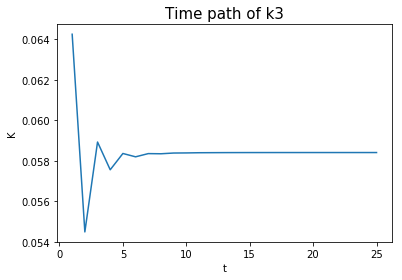

In [95]:
#Take the log of the first k2bar and k3bar where k2bar is equal to 0.8k2bar and k3bar is equal to 1.1k3bar
#find time path from that point. 

KK = np.zeros((2, T))
ZZ = np.zeros((T))

KK[0,0] = np.log(k3bar * 1.1) - np.log (k3bar)
KK[1,0] = np.log(k2bar * 0.8) - np.log (k2bar)

for j in range (1, T - 1):
    KK[:,j] = PP @ KK[:,j-1] + (QQ * ZZ[j]).reshape(2,)
    
KK[0,:] = k3bar * np.exp(KK[0,:])
KK[1,:] = k2bar * np.exp(KK[1,:])

KK0 = KK[:,:-1]
KK1 = KK[:,1:]

KKS = np.sum(KK, axis = 0)

time = np.arange(1, T+6).reshape(T+5,1)

Kvec_stable = np.zeros(((5, 1)))

for k in range(0, 5):
    Kvec_stable[k] = np.array([KK[0,T-1]])

k3_final = np.vstack((KK[0,:].reshape(20,1), Kvec_stable))
plt.plot(time, k3_final)
plt.title('Time path of k3', fontsize=15)
plt.xlabel(r't')
plt.ylabel(r'K')
plt.show()

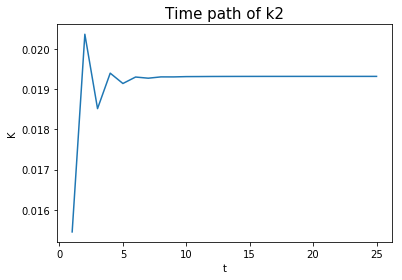

In [96]:
Kvec_stable = np.zeros(((5, 1)))

for k in range(0, 5):
    Kvec_stable[k] = np.array([KK[1,T-1]])

k2_final = np.vstack((KK[1,:].reshape(20,1), Kvec_stable))
plt.plot(time, k2_final)
plt.title('Time path of k2', fontsize=15)
plt.xlabel(r't')
plt.ylabel(r'K')
plt.show()

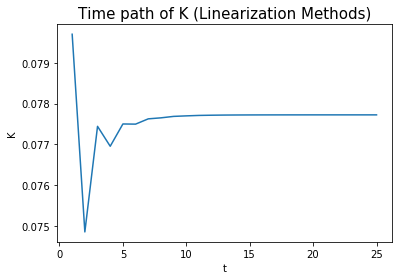

In [97]:
Kvec_stable = np.zeros(((5, 1)))

for k in range(0, 5):
    Kvec_stable[k] = np.array([KKS[T-1]])

kks_final = np.vstack((KKS.reshape(20,1), Kvec_stable))
plt.plot(time, kks_final)
plt.title('Time path of K (Linearization Methods)', fontsize=15)
plt.xlabel(r't')
plt.ylabel(r'K')
plt.show()

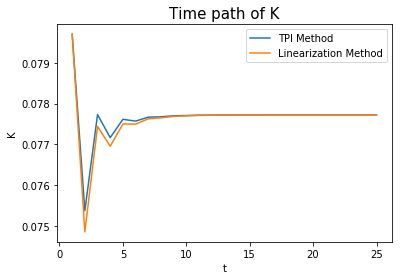

In [98]:
#Comparsion Graphs 

plt.plot(time,ktpi, label = 'TPI Method')
plt.plot(time, kks_final, label = 'Linearization Method')
plt.title('Time path of K', fontsize=15)
plt.xlabel(r't')
plt.ylabel(r'K')
plt.legend()
plt.show()

In [111]:
iterations = 10000
ystore = np.zeros((19, 10000))
cstore = np.zeros((19,10000))
istore = np.zeros((19,10000))
lstore = np.zeros((19,10000))

for n in range (0, iterations):

    rho = 0.9 ** 20
    eps = np.random.normal(0, 0.02, T)
    ZZ = np.zeros((T))
    for i in range (1, T):
        ZZ[i] = rho * ZZ[i-1] + eps[i]

    KK[0,0] = np.log(k3bar * 1.1) - np.log (k3bar)
    KK[1,0] = np.log(k2bar * 0.8) - np.log (k2bar)
    
    for j in range (1, T):
        KK[:,j] = PP @ KK[:,j-1] + (QQ * ZZ[j]).reshape(2,)
        
    KK[0,:] = k3bar * np.exp(KK[0,:])    
    KK[1,:] = k2bar * np.exp(KK[1,:])
    
    KK0 = KK[:,:-1]
    KK1 = KK[:,1:]

    K1, K2, K3, L, r1, r2, w1, w2, c11, c22, c21, c32, ys, invs, c31 = Modeldefs(KK0[0, :], KK1[0, :], KK0[0, :], KK1[0, :], KK0[0, :], KK1[0, :], 0, 0, params)

    cs = c11 + c21 + c31
    
    ystore[:,n] = ys
    cstore[:,n] = cs
    istore[:,n] = invs
    
print("done")

done


<IPython.core.display.Javascript object>


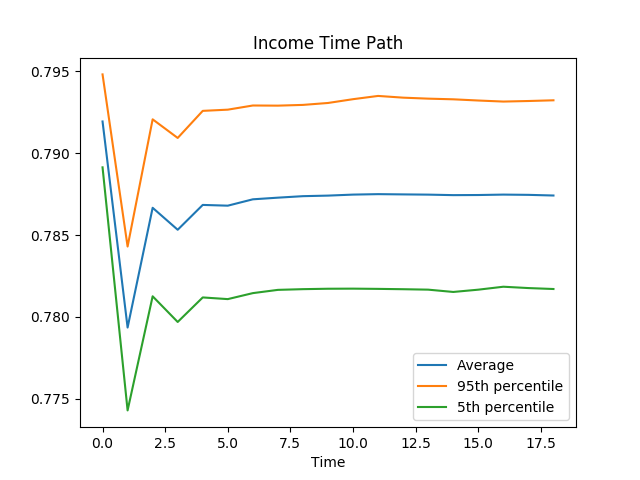

In [113]:
ymean = np.mean(ystore, axis = 1)
y95 = np.percentile(ystore, 95, axis = 1)
y5 = np.percentile(ystore, 5, axis = 1)

cmean = np.mean(cstore, axis = 1)
c95 = np.percentile(cstore, 95, axis = 1)
c5 = np.percentile(cstore, 5, axis = 1)

imean = np.mean(istore, axis = 1)
i95 = np.percentile(istore, 95, axis = 1)
i5 = np.percentile(istore, 5, axis = 1)

fig = plt.figure()
plt.plot(time, ymean, label = 'Average')
plt.plot(time, y95, label = '95th percentile')
plt.plot(time, y5, label = '5th percentile')
plt.title('Income Time Path')
plt.xlabel('Time')
plt.legend()

<IPython.core.display.Javascript object>


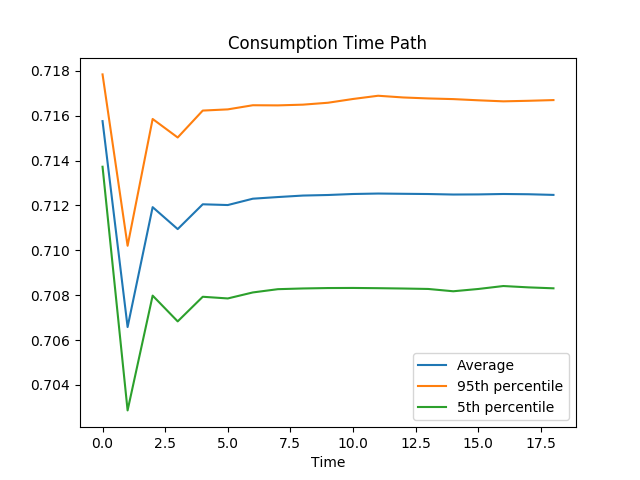

In [115]:
fig = plt.figure()
plt.plot(time, cmean, label = 'Average')
plt.plot(time, c95, label = '95th percentile')
plt.plot(time, c5, label = '5th percentile')
plt.title('Consumption Time Path')
plt.xlabel('Time')
plt.legend()

<IPython.core.display.Javascript object>


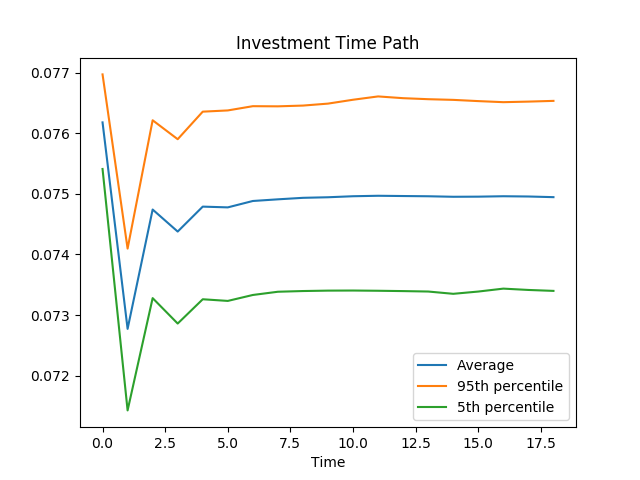

In [116]:
fig = plt.figure()
plt.plot(time, imean, label = 'Average')
plt.plot(time, i95, label = '95th percentile')
plt.plot(time, i5, label = '5th percentile')
plt.title('Investment Time Path')
plt.xlabel('Time')
plt.legend()